# NEW NEW_____

You need to figure out what you did that made wor2vec work so well. to way:
- 1 Find the first eorking github script!
- 2 Make a optimazation script to run a small grid search

You also need to only drop the count-vedtorization and work only wiht td-idf..

# NEW____

- Remove or rethink oversample.
- make the code more maintainable with functions...
    - you could just wait to the very last prediction test.
    
-impliment new word2vec model

In [1]:
# Basics -----------------------------------------------------
import pickle
from collections import defaultdict
import time

import numpy as np
import pandas as pd
from scipy import sparse
from scipy import spatial


import matplotlib.pyplot as plt
import seaborn as sns
import regex
import re


# NLTK -----------------------------------------------------

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#stop_words = set(nltk.corpus.stopwords.words("english"))

# Word2vec ----------------------------------------------------
import gensim

# SK learn --------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

from sklearn.decomposition import TruncatedSVD

from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sampling -------------------------------------------------

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

# DATA ------------------------------------------------------
df = pd.read_csv("labled_tweets.csv", index_col=0)

# Function I will need:

In [2]:
def roc_test(X, save_name = "roc_test.pdf", title = "some_title", model_names = ""):
    """X should be a list of tuples, where each tuple contains X_train at [0] and X_test at [1]"""
    plt.figure(figsize=[8,8])
    count = 0
    
    for i in X:
        clf_lg = LogisticRegression().fit(i[0], y_train)
        pred_proba_log = clf_lg.predict_proba(i[1])[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_log)
        auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
        plt.plot(fpr, tpr, label = model_names[count] + "AUC = " + str(auc))
        count +=1

    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle = "dashed", color = "orange")

    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)

    
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.title(title, fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize = 18)
    plt.grid(True)

    plt.legend(fontsize = 16)
    sns.despine(left=True, bottom= True)

    plt.savefig(save_name, bbox_inches="tight")
    plt.show()

In [3]:
# Simple feature selection

def simple_fs(X):
    """Where X is a touple countaning X-train [0] and X_test[1]"""
    clf_lg = LogisticRegression().fit(X[0], y_train)

    model = SelectFromModel(clf_lg, prefit=True)
    
    X_new_train = model.transform(X[0]) #It works becouse you have allready fitted the logistic regression on the trainset
    X_new_test = model.transform(X[1]) #It works becouse you have allready fitted the logistic regression on the trainset
    
    new_touple = (X_new_train, X_new_test)
    
    print("Old number of features: ",X[0].shape[1])
    print("New number of features",new_touple[0].shape[1])

    return(new_touple)


In [4]:
def recursive_fs(X):
    """Where X is a touple countaning X-train [0] and X_test[1]"""
    clf_lg = LogisticRegression()

    selector = RFECV(clf_lg, scoring = "roc_auc") 
    selector = selector.fit(X[0], y_train)
    
    X_new_train = model.transform(X[0]) 
    X_new_test = model.transform(X[1])
    
    new_touple = (X_new_train, X_new_test)
    
    print("Old number of features: ",X[0].shape[1])
    print("New number of features",new_touple[0].shape[1])

    return(new_touple)

In [5]:
def prep(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    return wordlist


In [6]:
def check_model(model, most_sim = "president"):
    print("Most similar to {}:\n".format(most_sim))
    for i in model.wv.most_similar(most_sim):
        print(i)

    print("\n")
    # get the Most common words
    print("Most common words:")
    print(model.wv.index2word[0], model.wv.index2word[1], model.wv.index2word[2])

    print("\n")
    # get the least common words
    vocab_size = len(model.wv.vocab)
    print("Least common words:")
    print(model.wv.index2word[vocab_size - 1], model.wv.index2word[vocab_size - 2], model.wv.index2word[vocab_size - 3])

    print("\n")
    # some similarity fun
    print("Sanity sim check1:")
    print(model.wv.similarity('woman', 'man'), model.wv.similarity('woman', 'thing'))

    print("\n")
    print("Sanity sim check2:")
    # what doesn't fit?
    print(model.wv.doesnt_match("green blue red man".split()))

# Split for inner and outer layer:

In [7]:
y = df["lacking_dem_pref"]
X = df["text"]

# Outer layer
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X, y, test_size=0.20, random_state=42)

# inner layer
X_train, X_test, y_train, y_test = train_test_split(X_train_out, y_train_out, test_size=0.20, random_state=42)


# Term document matrix:

# Preproccesing

In [8]:
#words = prep(df.text.to_string())

words = prep(X_train.to_string())

len(words)

36804

In [9]:
# For all text (why did you use wordF)
dist = nltk.FreqDist(words)
print("all tweets:")
print(dist.most_common(20))
print("\n","-------------------")

all tweets:
[('...', 3191), ('@', 1411), ('the', 1323), (':', 974), ('to', 826), (',', 660), ('rt', 614), ('#', 585), ('a', 568), ('.', 396), ('i', 396), ('of', 365), ('and', 319), ('is', 317), ('in', 310), ('on', 305), ('for', 272), ('we', 215), ('you', 205), ('with', 196)]

 -------------------


In [10]:
high_freq_remove = []
low_freq_remove = []

for i, j in dist.items():
    if j >= 400:
        high_freq_remove.append(i)
    elif j <= 3:
        low_freq_remove.append(i)

n_low_remove = len(low_freq_remove)
n_high_remove = len(high_freq_remove)

print(n_low_remove)
print(n_high_remove)

full_freq_remove = high_freq_remove + low_freq_remove

print(len(full_freq_remove))

5973
9
5982


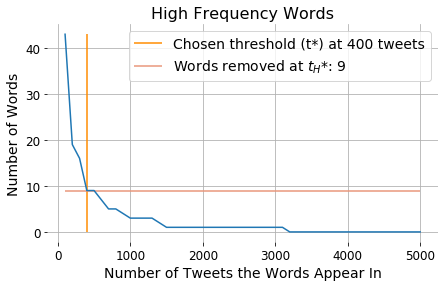

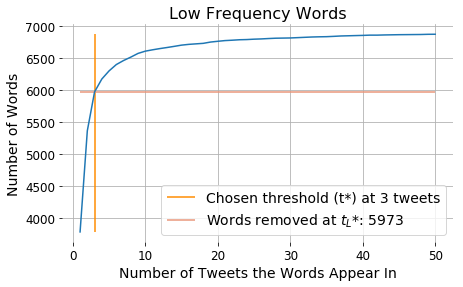

In [11]:
# SKAL DET HER SÅ BARE VÆK?

# High frequency words
high_threshold = 400
high_freq = {}

high_range = np.arange(100,5100,100)

plt.figure(figsize = [7,4])

for i in high_range:
    temp_freq = []
    for k, v in dist.items():
        if v >= i:
            temp_freq.append(k)
    high_freq["freq"+str(i)] = len(temp_freq)

max_high = max(list(high_freq.values()))
min_high = min(list(high_freq.values()))
    
plt.plot(high_range, list(high_freq.values()))
plt.vlines(400, min_high,max_high, colors= "darkorange", 
           label = "Chosen threshold (t*) at "+str(high_threshold) +" tweets")

plt.hlines(n_high_remove, high_range[0], high_range[-1], colors= "darksalmon",
          label = "Words removed at $t_H$*: " + str(n_high_remove))

plt.title("High Frequency Words", fontsize = 16)
plt.ylabel("Number of Words", fontsize = 14)
plt.xlabel("Number of Tweets the Words Appear In", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(bottom=True, left=True)
plt.grid()
plt.legend(fontsize = 14)
plt.savefig('high_freq.pdf', bbox_inches="tight")

plt.show()


# Low frecuncy words
low_threshold = 3
low_freq = {}

low_range = np.arange(1,51,1)

plt.figure(figsize = [7,4])

for i in low_range:
    temp_freq = []
    for k, v in dist.items():
        if v <= i:
            temp_freq.append(k)
    low_freq["freq"+str(i)] = len(temp_freq)

max_low = max(list(low_freq.values()))
min_low = min(list(low_freq.values()))

plt.plot(low_range, list(low_freq.values()))
plt.vlines(low_threshold, min_low,max_low, colors= "darkorange", 
           label = "Chosen threshold (t*) at "+str(low_threshold)+" tweets")

plt.hlines(n_low_remove, low_range[0], low_range[-1], colors= "darksalmon",
          label = "Words removed at $t_L$*: " + str(n_low_remove))

plt.title("Low Frequency Words", fontsize = 16)
plt.ylabel("Number of Words", fontsize = 14)
plt.xlabel("Number of Tweets the Words Appear In", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

sns.despine(bottom=True, left=True)
plt.grid()
plt.legend(fontsize = 14)
plt.savefig('low_freq.pdf', bbox_inches="tight")

plt.show()

# Cross validation for low freq words:

### Count:

In [12]:
stop_words = set(nltk.corpus.stopwords.words("english"))


low_freq_remove = defaultdict(list)
freq_range = np.arange(1,5,1)

for i, j in dist.items():
    for n in freq_range:
        dict_key = "r_" + str(n)
        if j <= n:
            low_freq_remove[dict_key].append(i)

low_freq_remove["r_0"] = []# for no remove
            
for i,j in low_freq_remove.items():
    
    def prep2(text):
        wordlist = nltk.word_tokenize(text)
        wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
        wordlist = [w for w in wordlist if w not in stop_words and w not in j]
        return wordlist
    
    unigram_vectorizer = CountVectorizer(tokenizer=prep2)
    bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
    trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

    X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_1C = unigram_vectorizer.transform(X_test)
    
    X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_2C = bigram_vectorizer.transform(X_test)

    X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_3C = trigram_vectorizer.transform(X_test)
    
    X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
    X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

        
    clf_lg = LogisticRegression().fit(X_train_dtm_1C, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_1C)[:,1]

    auc1 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_2C, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_2C)[:,1]

    auc2 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_3C, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_3C)[:,1]

    auc3 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    clf_lg = LogisticRegression().fit(X_train_dtm_allC, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_allC)[:,1]

    aucall = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    (print(str(i)+" auc: uni_gram " + str(auc1) + ", bi_gram " + str(auc2) + ", tri_gram " + str(auc3) + ", combined " + str(aucall)))
    
# make a plot
# make i possible to extract the highest score

    
#plt.show()    

r_2 auc: uni_gram 0.912, bi_gram 0.836, tri_gram 0.741, combined 0.905
r_3 auc: uni_gram 0.91, bi_gram 0.832, tri_gram 0.737, combined 0.898
r_4 auc: uni_gram 0.91, bi_gram 0.832, tri_gram 0.725, combined 0.896
r_1 auc: uni_gram 0.922, bi_gram 0.847, tri_gram 0.734, combined 0.91
r_0 auc: uni_gram 0.924, bi_gram 0.851, tri_gram 0.746, combined 0.91


### Tf-idf:

In [13]:
stop_words = set(nltk.corpus.stopwords.words("english"))

low_freq_remove = defaultdict(list)
freq_range = np.arange(1,5,1)

for i, j in dist.items():
    for n in freq_range:
        dict_key = "r_" + str(n)
        if j <= n:
            low_freq_remove[dict_key].append(i)

low_freq_remove["r_0"] = []# for no remove
            
for i,j in low_freq_remove.items():
    
    def prep2(text):
        wordlist = nltk.word_tokenize(text)
        wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
        wordlist = [w for w in wordlist if w not in stop_words and w not in j]
        return wordlist
    
    unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
    bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
    trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)
    
    X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_1T = unigram_vectorizer.transform(X_test)
    
    X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_2T = bigram_vectorizer.transform(X_test)

    X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_3T = trigram_vectorizer.transform(X_test)
    
    X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
    X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

        
    clf_lg = LogisticRegression().fit(X_train_dtm_1T, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_1T)[:,1]

    auc1 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_2T, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_2T)[:,1]

    auc2 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_3T, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_3T)[:,1]

    auc3 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    clf_lg = LogisticRegression().fit(X_train_dtm_allT, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_allT)[:,1]

    aucall = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    (print(str(i)+" auc: uni_gram " + str(auc1) + ", bi_gram " + str(auc2) + ", tri_gram " + str(auc3) + ", combined " + str(aucall)))
    
# make a plot
# make i possible to extract the highest score

    
#plt.show()    

r_2 auc: uni_gram 0.918, bi_gram 0.846, tri_gram 0.736, combined 0.92
r_3 auc: uni_gram 0.917, bi_gram 0.847, tri_gram 0.734, combined 0.918
r_4 auc: uni_gram 0.914, bi_gram 0.846, tri_gram 0.718, combined 0.915
r_1 auc: uni_gram 0.922, bi_gram 0.859, tri_gram 0.726, combined 0.922
r_0 auc: uni_gram 0.924, bi_gram 0.859, tri_gram 0.738, combined 0.923


### interim conclusion: no gains by removing low frequency words

# Cross validation of High Frequency words

## Count:

In [14]:
stop_words = set(nltk.corpus.stopwords.words("english"))


high_freq_remove = defaultdict(list)
freq_range = np.arange(100,1550,100)

for i, j in dist.items():
    for n in freq_range:
        dict_key = "r_" + str(n)
        if j >= n:
            high_freq_remove[dict_key].append(i)

for i,j in high_freq_remove.items():
    
    def prep2(text):
        wordlist = nltk.word_tokenize(text)
        wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
        wordlist = [w for w in wordlist if w not in stop_words and w not in j]
        return wordlist
    
    unigram_vectorizer = CountVectorizer(tokenizer=prep2)
    bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
    trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

    X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_1C = unigram_vectorizer.transform(X_test)
    
    X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_2C = bigram_vectorizer.transform(X_test)

    X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_3C = trigram_vectorizer.transform(X_test)
    
    X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
    X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

        
    clf_lg = LogisticRegression().fit(X_train_dtm_1C, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_1C)[:,1]

    auc1 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_2C, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_2C)[:,1]

    auc2 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_3C, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_3C)[:,1]

    auc3 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    clf_lg = LogisticRegression().fit(X_train_dtm_allC, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_allC)[:,1]

    aucall = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    (print(str(i)+" auc: uni_gram " + str(auc1) + ", bi_gram " + str(auc2) + ", tri_gram " + str(auc3) + ", combined " + str(aucall)))
    
# make a plot
# make i possible to extract the highest score

    
#plt.show()    

r_100 auc: uni_gram 0.925, bi_gram 0.831, tri_gram 0.647, combined 0.925
r_200 auc: uni_gram 0.927, bi_gram 0.842, tri_gram 0.683, combined 0.924
r_300 auc: uni_gram 0.927, bi_gram 0.842, tri_gram 0.683, combined 0.924
r_400 auc: uni_gram 0.927, bi_gram 0.851, tri_gram 0.698, combined 0.92
r_500 auc: uni_gram 0.927, bi_gram 0.851, tri_gram 0.698, combined 0.92
r_600 auc: uni_gram 0.927, bi_gram 0.859, tri_gram 0.694, combined 0.921
r_700 auc: uni_gram 0.927, bi_gram 0.863, tri_gram 0.701, combined 0.921
r_800 auc: uni_gram 0.927, bi_gram 0.863, tri_gram 0.701, combined 0.921
r_900 auc: uni_gram 0.927, bi_gram 0.863, tri_gram 0.701, combined 0.921
r_1000 auc: uni_gram 0.927, bi_gram 0.85, tri_gram 0.741, combined 0.918
r_1100 auc: uni_gram 0.927, bi_gram 0.85, tri_gram 0.741, combined 0.918
r_1200 auc: uni_gram 0.927, bi_gram 0.85, tri_gram 0.741, combined 0.918
r_1300 auc: uni_gram 0.927, bi_gram 0.85, tri_gram 0.741, combined 0.918
r_1400 auc: uni_gram 0.927, bi_gram 0.85, tri_gram 0.

## Td-idf

In [15]:
stop_words = set(nltk.corpus.stopwords.words("english"))


high_freq_remove = defaultdict(list)
freq_range = np.arange(100,1550,100)

for i, j in dist.items():
    for n in freq_range:
        dict_key = "r_" + str(n)
        if j >= n:
            high_freq_remove[dict_key].append(i)

for i,j in high_freq_remove.items():
    
    def prep2(text):
        wordlist = nltk.word_tokenize(text)
        wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
        wordlist = [w for w in wordlist if w not in stop_words and w not in j]
        return wordlist
    
    unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
    bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
    trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)
    
    X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_1T = unigram_vectorizer.transform(X_test)
    
    X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_2T = bigram_vectorizer.transform(X_test)

    X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
    X_test_dtm_3T = trigram_vectorizer.transform(X_test)
    
    X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
    X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

        
    clf_lg = LogisticRegression().fit(X_train_dtm_1T, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_1T)[:,1]

    auc1 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_2T, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_2T)[:,1]

    auc2 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    clf_lg = LogisticRegression().fit(X_train_dtm_3T, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_3T)[:,1]

    auc3 = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    clf_lg = LogisticRegression().fit(X_train_dtm_allT, y_train)
    pred_proba_log = clf_lg.predict_proba(X_test_dtm_allT)[:,1]

    aucall = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
    
    
    (print(str(i)+" auc: uni_gram " + str(auc1) + ", bi_gram " + str(auc2) + ", tri_gram " + str(auc3) + ", combined " + str(aucall)))
    
# make a plot
# make i possible to extract the highest score
    
#plt.show()    

r_100 auc: uni_gram 0.93, bi_gram 0.841, tri_gram 0.651, combined 0.932
r_200 auc: uni_gram 0.93, bi_gram 0.846, tri_gram 0.671, combined 0.933
r_300 auc: uni_gram 0.93, bi_gram 0.846, tri_gram 0.671, combined 0.933
r_400 auc: uni_gram 0.931, bi_gram 0.864, tri_gram 0.691, combined 0.935
r_500 auc: uni_gram 0.931, bi_gram 0.864, tri_gram 0.691, combined 0.935
r_600 auc: uni_gram 0.928, bi_gram 0.865, tri_gram 0.695, combined 0.934
r_700 auc: uni_gram 0.928, bi_gram 0.865, tri_gram 0.708, combined 0.934
r_800 auc: uni_gram 0.928, bi_gram 0.865, tri_gram 0.708, combined 0.934
r_900 auc: uni_gram 0.928, bi_gram 0.865, tri_gram 0.708, combined 0.934
r_1000 auc: uni_gram 0.925, bi_gram 0.857, tri_gram 0.732, combined 0.926
r_1100 auc: uni_gram 0.925, bi_gram 0.857, tri_gram 0.732, combined 0.926
r_1200 auc: uni_gram 0.925, bi_gram 0.857, tri_gram 0.732, combined 0.926
r_1300 auc: uni_gram 0.925, bi_gram 0.857, tri_gram 0.732, combined 0.926
r_1400 auc: uni_gram 0.925, bi_gram 0.857, tri_gra

### interim conclusion: indeed gains by removing high frequency words

In [16]:
full_remove = high_freq_remove["r_500"] # you have eliminated short remove
full_remove

['@', 'a', '...', 'rt', ':', ',', 'to', 'the', '#']

In [17]:

# A pickle for the word2vec implimentation
output = open('full_remove.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(full_remove, output)

output.close()

# The chosen prep function:

In [18]:
def prep2(text):
    wordlist = nltk.word_tokenize(text)
    wordlist = [lemmatizer.lemmatize(w.lower()) for w in wordlist]
    wordlist = [w for w in wordlist if w not in stop_words and w not in high_freq_remove["r_500"]]# foun in the outputs above
    return wordlist

words_processed = prep2(X_train.to_string())
len(words_processed)

19884

## Count vectorizer

In [19]:
unigram_vectorizer = CountVectorizer(tokenizer=prep2) 
bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1C = unigram_vectorizer.transform(X_test)

X_dtm_1C = (X_train_dtm_1C, X_test_dtm_1C)

X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2C = bigram_vectorizer.transform(X_test)

X_dtm_2C = (X_train_dtm_2C, X_test_dtm_2C)

X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3C = trigram_vectorizer.transform(X_test)

X_dtm_3C = (X_train_dtm_3C, X_test_dtm_3C)

# --------------------------------------------

X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

X_dtm_allC = (X_train_dtm_allC, X_test_dtm_allC)

# ------------------------------------------
X_dtm_C = [X_dtm_1C, X_dtm_2C, X_dtm_3C, X_dtm_allC]

In [20]:
# unigram_featuresC = unigram_vectorizer.get_feature_names()
# bigram_featuresC = bigram_vectorizer.get_feature_names()
# trigram_featuresC = trigram_vectorizer.get_feature_names()

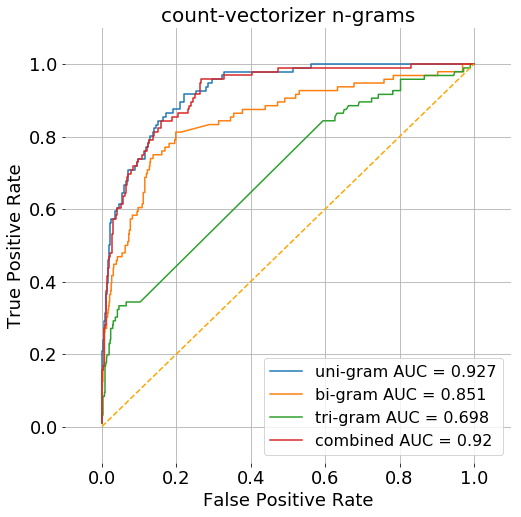

In [21]:
model_names = ["uni-gram ", "bi-gram ", "tri-gram ", "combined "]
roc_test(X_dtm_C, title= "count-vectorizer n-grams", save_name="cv_ngram.pdf", model_names=model_names)

In [22]:
X_dtm_allC_FS =simple_fs(X_dtm_allC)

Old number of features:  75852
New number of features 17222


In [23]:
X_dtm_allC_RFS =simple_fs(X_dtm_allC_FS)

Old number of features:  17222
New number of features 6619


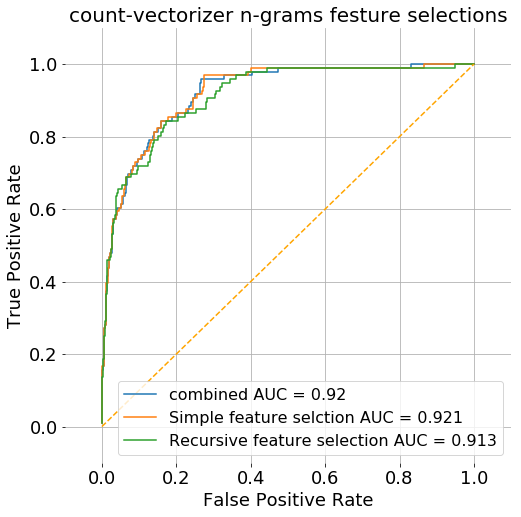

In [24]:
X_dtm_C_FS_list = [X_dtm_allC, X_dtm_allC_FS, X_dtm_allC_RFS]

model_names = ["combined ", "Simple feature selction ", "Recursive feature selection "]
roc_test(X_dtm_C_FS_list, title= "count-vectorizer n-grams festure selections", save_name="cv_ngram_fs.pdf", model_names=model_names)

## tf-idf vectorizer

In [25]:
unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1T = unigram_vectorizer.transform(X_test)

X_dtm_1T = (X_train_dtm_1T, X_test_dtm_1T)


X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2T = bigram_vectorizer.transform(X_test)

X_dtm_2T = (X_train_dtm_2T, X_test_dtm_2T)


X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3T = trigram_vectorizer.transform(X_test)

X_dtm_3T = (X_train_dtm_3T, X_test_dtm_3T)

# -----------------------------------------------
X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

X_dtm_allT = (X_train_dtm_allT, X_test_dtm_allT)

# ------------------------------------------

X_dtm_T = [X_dtm_1T, X_dtm_2T, X_dtm_3T, X_dtm_allT]

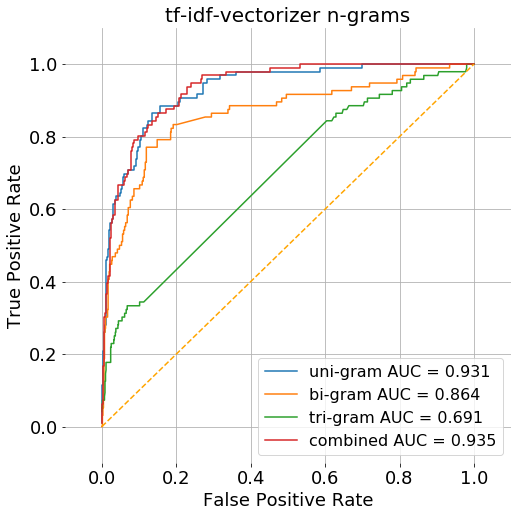

In [26]:
model_names = ["uni-gram ", "bi-gram ", "tri-gram ", "combined "]
roc_test(X_dtm_T, title= "tf-idf-vectorizer n-grams", save_name="tv_ngram.pdf", model_names=model_names)

In [27]:
X_dtm_allT_FS =simple_fs(X_dtm_allT)

Old number of features:  75852
New number of features 14125


In [28]:
X_dtm_allT_RFS =simple_fs(X_dtm_allT_FS)

Old number of features:  14125
New number of features 5858


In [29]:
X_dtm_allT_RFS

(<3263x5858 sparse matrix of type '<class 'numpy.float64'>'
 	with 33643 stored elements in Compressed Sparse Row format>,
 <816x5858 sparse matrix of type '<class 'numpy.float64'>'
 	with 7175 stored elements in Compressed Sparse Row format>)

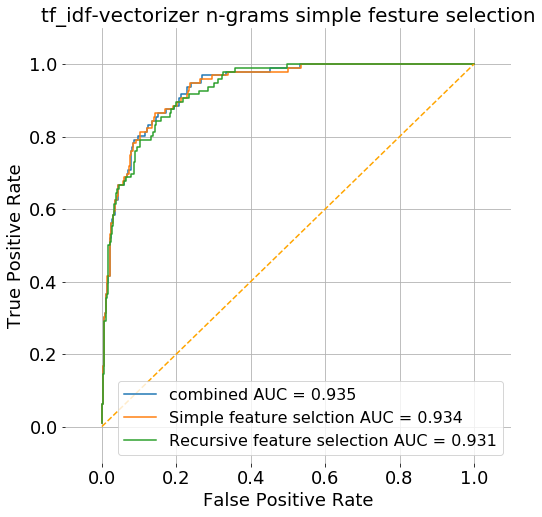

In [30]:
X_dtm_T_FS_list = [X_dtm_allT, X_dtm_allT_FS, X_dtm_allT_RFS]

model_names = ["combined ", "Simple feature selction ", "Recursive feature selection "]
roc_test(X_dtm_T_FS_list, title= "tf_idf-vectorizer n-grams simple festure selection", save_name="tv_ngram_fs.pdf", model_names=model_names)

## Combined

In [31]:
X_train_dtm_all = sparse.hstack([X_train_dtm_allT, X_train_dtm_allC])
X_test_dtm_all = sparse.hstack([X_test_dtm_allT, X_test_dtm_allC])

X_dtm_all = (X_train_dtm_all, X_test_dtm_all)

X_dtm = [X_dtm_all]

In [32]:
# # Maybe for later use
# features_vector = unigram_featuresC + bigram_featuresC + trigram_featuresC +unigram_featuresT + bigram_featuresT + trigram_featuresT

In [33]:
X_dtm_all_FS =simple_fs(X_dtm_all)

Old number of features:  151704
New number of features 35451


In [34]:
X_dtm_all_RFS =simple_fs(X_dtm_all_FS)

Old number of features:  35451
New number of features 10429


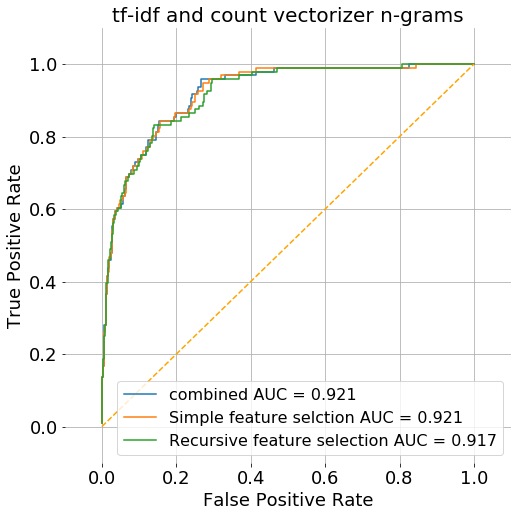

In [35]:
X_dtm_all_FS_list = [X_dtm_all, X_dtm_all_FS, X_dtm_all_RFS]

# but wat if you included feature selection?

model_names = ["combined ", "Simple feature selction ", "Recursive feature selection "]
roc_test(X_dtm_all_FS_list, title= "tf-idf and count vectorizer n-grams", save_name="all_ngram.pdf", model_names=model_names)

# Interim Conclusion:.... SHould you just use the full tf_idf?.. Yep

----
# Number of !, ?, @, and # - This you don't use in the final thing..

In [36]:
def count_symb(X):
    count_att = []
    count_exclamation = []
    count_question = []
    count_hashtags = []

    for i in X:
        count_att.append(i.count("@"))
        count_exclamation.append(i.count("!"))
        count_question.append(i.count("?"))
        count_hashtags.append(i.count("#"))

    count_df = pd.DataFrame([count_att,count_exclamation,count_question,count_hashtags]).T
    count_df.columns = {"count_att":0,"count_exclamation":1,"count_question":2,"count_hashtags":3}

    return(sparse.csr_matrix(count_df))
    

In [37]:
# # for later use maybe
# count_features = ["count_att","count_exclamation","count_question","count_hashtags"]
# features_vector = features_vector + count_features

In [38]:
X_train_count_symb = count_symb(X_train)
X_test_count_symb = count_symb(X_test)

---

In [39]:
# Det er måske denne her du skal ignorere?
X_train_dtm_all_count = sparse.hstack([X_train_dtm_all, X_train_count_symb])
X_test_dtm_all_count = sparse.hstack([X_test_dtm_all, X_test_count_symb])

---

In [40]:
X_dtm_all_count = (X_train_dtm_all_count, X_test_dtm_all_count)
X_dtm_count = [X_dtm_all_count]

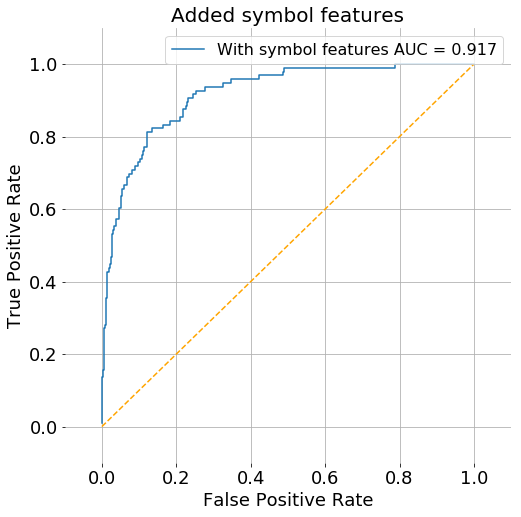

In [41]:
model_names = ["With symbol features "]
roc_test(X_dtm_count, title= "Added symbol features", save_name="symbols.pdf", model_names=model_names)

----


----

# Features from word2vec------------------------------------------------
REMEMBER YOU CAN JUST LOAD YOUR MODEL NOW!!!!

## Make the word2vec model

----

In [62]:
#df_unlabled_big = pd.read_csv("/media/polichinel/DATA/backup/PDS_DATA/new_many_tweets.csv", index_col= 0)
df_unlabled_big1 = pd.read_csv("new_all_unlabeled_tweets1.csv", index_col= 0)
df_unlabled_big2 = pd.read_csv("new_all_unlabeled_tweets2.csv", index_col= 0)

df_unlabled = pd.read_csv("all_unlabled_tweets.csv", index_col= 0)
df_labled = pd.read_csv("labled_tweets.csv", index_col= 0)

pkl_file = open('full_remove.pkl', 'rb') # from feature set.
full_remove = pickle.load(pkl_file)
pkl_file.close()

/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1,4,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
path = "/media/polichinel/DATA/backup/PDS_DATA/"

spec_path = path + "hot_comments_politics.pkl"


pkl_file = open(spec_path, 'rb') # from feature set.
comments1 = pickle.load(pkl_file)
pkl_file.close()

# ---------------------------------------

spec_path = path + "controversial_comments_politics.pkl"

pkl_file = open(spec_path, 'rb') # from feature set.
comments2 = pickle.load(pkl_file)
pkl_file.close()

# ---------------------------------------

spec_path = path + "hot_comments_news.pkl"

pkl_file = open(spec_path, 'rb') # from feature set.
comments3 = pickle.load(pkl_file)
pkl_file.close()

# ---------------------------------------

spec_path = path + "controversial_comments_news.pkl"

pkl_file = open(spec_path, 'rb') # from feature set.
comments4 = pickle.load(pkl_file)
pkl_file.close()

# ---------------------------------------

spec_path = path + "top_comments_politics.pkl"


pkl_file = open(spec_path, 'rb') # from feature set.
comments5 = pickle.load(pkl_file)
pkl_file.close()


# ---------------------------------------

spec_path = path + "top_comments_news.pkl"


pkl_file = open(spec_path, 'rb') # from feature set.
comments6 = pickle.load(pkl_file)
pkl_file.close()

# ---------------------------------------

comments_all = comments1 + comments2 + comments3 + comments4 + comments5 + comments6
all_text = comments_all + list(df_unlabled_big1.text) + list(df_unlabled_big2.text) + list(df_unlabled.text)

# ---------------------------------------

len(all_text)


2539464

From the grid search I have choosen to use the hyperparameters 450, 10, 40, 0.0001 (1e-4) for the model

In [64]:
# Set values for various parameters
feature_size = 450    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 40   # Minimum word count             HERE           
sample = 1e-4   # Downsample setting for frequent words


In [65]:
# tweets are back from 140 character limit; not 240!
%time sentences = [prep2(sent) for sent in nltk.sent_tokenize(pd.Series(all_text).to_string())]

CPU times: user 11min 38s, sys: 2.15 s, total: 11min 40s
Wall time: 11min 41s


In [80]:
# A pickle for the word2vec implimentation
output = open('sentences.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(sentences, output)

output.close()


In [ ]:
pkl_file = open('sentences.pkl', 'rb') # from feature set.
sentences = pickle.load(pkl_file)
pkl_file.close()

In [93]:
#spec_model = gensim.models.Word2Vec(sentences, size=fs, window=wc, min_count=mwc, sample=s, sg = 1, seed = 42, workers = 8) # helps, but still not deterministic


In [81]:
%time model = gensim.models.Word2Vec(sentences, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, sg = 1, seed = 42, workers = 8)
len(list(model.wv.vocab.keys())) # Men, med min_count = 10 har du kun 1650 obs... Flere tweets mere text.

CPU times: user 30min 52s, sys: 4.23 s, total: 30min 57s
Wall time: 5min 17s


17463

In [58]:
check_model(model)

Most similar to president:

('pres', 0.5701441168785095)
('administration', 0.5664738416671753)
('obama', 0.5496500730514526)
('potus', 0.5491422414779663)
('trump', 0.5209234356880188)
("'s", 0.5143622756004333)
('presi', 0.49522650241851807)
('p', 0.4861907362937927)
('executi', 0.48565244674682617)
('whitehous', 0.4853307902812958)


Most common words:
. 's ’


Least common words:
uw_rowing foreignpolicyi nwsneworleans


Sanity sim check1:
0.24419105299739619 0.15396334419769403


Sanity sim check2:
man


In [91]:
# A pickle for the word2vec implimentation
output = open('word2vec_model.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(model, output)

output.close()

model.save("word2vec_model_final") # just extra

In [ ]:
# can also save it as a w2vmodel

----

---

## Making the embeddign-features

In [42]:
#no need if you allready have it.

pkl_file = open('word2vec_model.pkl', 'rb')
model = pickle.load(pkl_file)
output.close()

If you have allredy compiled the model save a tone of time by importing the pickle:

In [43]:
word2vec_model = model.wv
del model # to save ram

### Some new functions:

In [44]:
n_features = word2vec_model.word_vec("potus").shape[0]
index2word_set = set(word2vec_model.index2word)

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return(feature_vec)

def word_vectorizer(X):
    """Where X is either X_test or X_train"""
    data_set = pd.DataFrame(np.zeros([len(X),n_features]))
    vectors = np.zeros(n_features)
    dividend = 0


    for i in range(len(X)):
        sent_list = []
        strings = X.iloc[i].split()
        for j in range(len(strings)):
            word = prep2(strings[j].lower())
            if len(word) > 0:
                clean_word = re.sub(r'[^\w\s]','',word[0])
                sent_list.append(clean_word)
                sent = " ".join(sent_list)

                data_set.iloc[i] = avg_feature_vector(sent, model=word2vec_model, num_features=n_features, index2word_set=index2word_set)
                
    return(data_set)

w2v_train_df_new = word_vectorizer(X_train)
w2v_test_df_new = word_vectorizer(X_test)

# Stupid framework you have created:
X_w2v_new = (w2v_train_df_new, w2v_test_df_new)
X_w2v_list_new = [X_w2v_new]

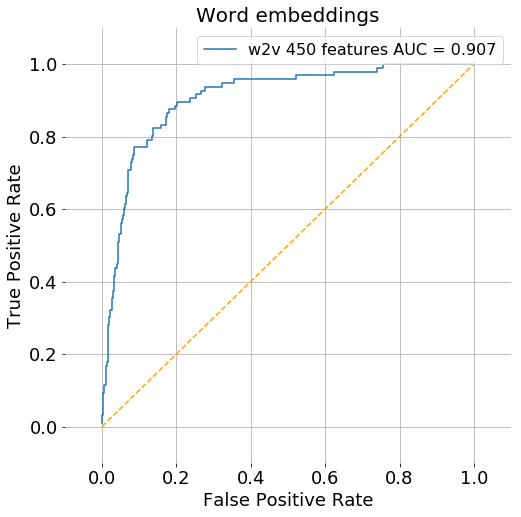

In [45]:
#  was 0.866
model_names = ["w2v 450 features "]
roc_test(X_w2v_list_new, title= "Word embeddings", save_name="w2v_roc.pdf", model_names=model_names)

# Merge with the various tf-idf set

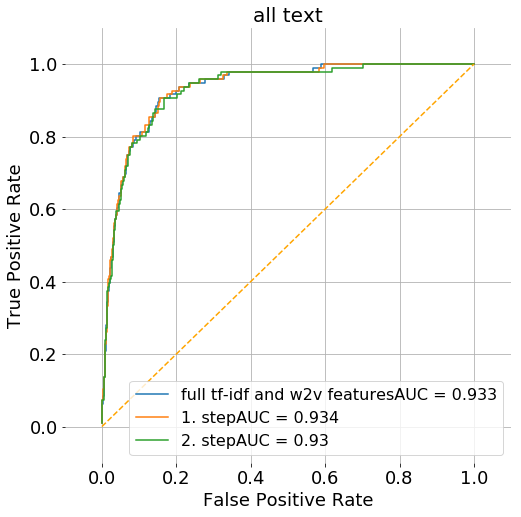

In [46]:
# yeah, a unprudent reuse, but it'll do
X_train_T_v2w = sparse.hstack([X_train_dtm_allT, w2v_train_df_new])
X_test_T_w2v = sparse.hstack([X_test_dtm_allT, w2v_test_df_new])

X_dtm_T_v2w = (X_train_T_v2w, X_test_T_w2v)
X_dtm_T_v2w_list = [X_dtm_T_v2w]



X_train_T_FS_v2w = sparse.hstack([X_dtm_allT_FS[0], w2v_train_df_new])
X_test_T_FS_w2v = sparse.hstack([X_dtm_allT_FS[1], w2v_test_df_new])

X_dtm_T_FS_v2w = (X_train_T_FS_v2w, X_test_T_FS_w2v)
X_dtm_T_v2w_FS_list = [X_dtm_T_FS_v2w]



X_train_T_RFS_v2w = sparse.hstack([X_dtm_allT_RFS[0], w2v_train_df_new])
X_test_T_RFS_w2v = sparse.hstack([X_dtm_allT_RFS[1], w2v_test_df_new])

X_dtm_T_RFS_v2w = (X_train_T_RFS_v2w, X_test_T_RFS_w2v)
X_dtm_T_v2w_RFS_list = [X_dtm_T_RFS_v2w]


X_dtm_T_v2w_all_list = X_dtm_T_v2w_list + X_dtm_T_v2w_FS_list + X_dtm_T_v2w_RFS_list

#  was 0.887
model_names = ["full tf-idf and w2v features", "1. step", "2. step"]
roc_test(X_dtm_T_v2w_all_list, title= "all text", save_name="tf_idf_w2v_roc.pdf", model_names=model_names)

In [47]:
print(X_dtm_T_v2w[0].shape[1])
print(X_dtm_T_FS_v2w[0].shape[1])
print(X_dtm_T_RFS_v2w[0].shape[1])

76302
14575
6308


# Merge with the various count set

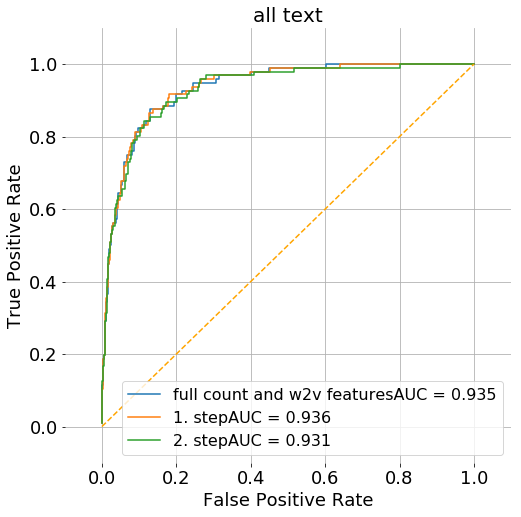

In [48]:
# yeah, a unprudent reuse, but it'll do
X_train_C_v2w = sparse.hstack([X_train_dtm_allC, w2v_train_df_new])
X_test_C_w2v = sparse.hstack([X_test_dtm_allC, w2v_test_df_new])

X_dtm_C_v2w = (X_train_C_v2w, X_test_C_w2v)
X_dtm_C_v2w_list = [X_dtm_C_v2w]



X_train_C_FS_v2w = sparse.hstack([X_dtm_allC_FS[0], w2v_train_df_new])
X_test_C_FS_w2v = sparse.hstack([X_dtm_allC_FS[1], w2v_test_df_new])

X_dtm_C_FS_v2w = (X_train_C_FS_v2w, X_test_C_FS_w2v)
X_dtm_C_v2w_FS_list = [X_dtm_C_FS_v2w]



X_train_C_RFS_v2w = sparse.hstack([X_dtm_allC_RFS[0], w2v_train_df_new])
X_test_C_RFS_w2v = sparse.hstack([X_dtm_allC_RFS[1], w2v_test_df_new])

X_dtm_C_RFS_v2w = (X_train_C_RFS_v2w, X_test_C_RFS_w2v)
X_dtm_C_v2w_RFS_list = [X_dtm_C_RFS_v2w]


X_dtm_C_v2w_all_list = X_dtm_C_v2w_list + X_dtm_C_v2w_FS_list + X_dtm_C_v2w_RFS_list

#  was 0.887
model_names = ["full count and w2v features", "1. step", "2. step"]
roc_test(X_dtm_C_v2w_all_list, title= "all text", save_name="tf_idf_w2v_roc.pdf", model_names=model_names)

In [49]:
print(X_dtm_C_v2w[0].shape[1])
print(X_dtm_C_FS_v2w[0].shape[1])
print(X_dtm_C_RFS_v2w[0].shape[1])

76302
17672
7069


# Merge with the the various combined set

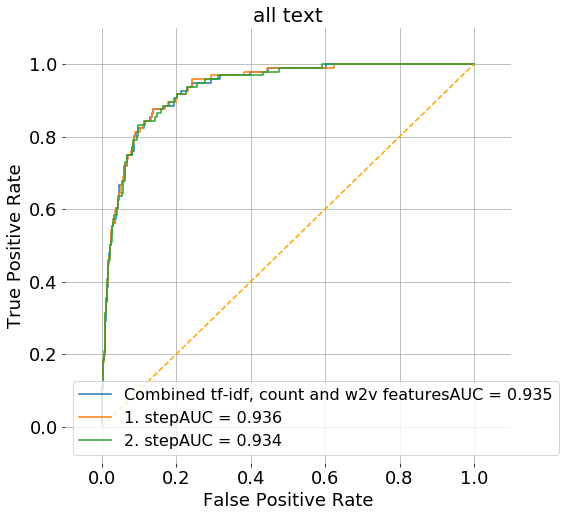

In [50]:
# yeah, a unprudent reuse, but it'll do
X_train_v2w = sparse.hstack([X_dtm_all[0], w2v_train_df_new])
X_test_w2v = sparse.hstack([X_dtm_all[1], w2v_test_df_new])

X_dtm_v2w = (X_train_v2w, X_test_w2v)
X_dtm_v2w_list = [X_dtm_v2w]



X_train_FS_v2w = sparse.hstack([X_dtm_all_FS[0], w2v_train_df_new])
X_test_FS_w2v = sparse.hstack([X_dtm_all_FS[1], w2v_test_df_new])

X_dtm_FS_v2w = (X_train_FS_v2w, X_test_FS_w2v)
X_dtm_v2w_FS_list = [X_dtm_FS_v2w]



X_train_RFS_v2w = sparse.hstack([X_dtm_all_RFS[0], w2v_train_df_new])
X_test_RFS_w2v = sparse.hstack([X_dtm_all_RFS[1], w2v_test_df_new])

X_dtm_RFS_v2w = (X_train_RFS_v2w, X_test_RFS_w2v)
X_dtm_v2w_RFS_list = [X_dtm_RFS_v2w]


X_dtm_v2w_all_list = X_dtm_v2w_list + X_dtm_v2w_FS_list + X_dtm_v2w_RFS_list

#  was 0.887
model_names = ["Combined tf-idf, count and w2v features", "1. step", "2. step"]
roc_test(X_dtm_v2w_all_list, title= "all text", save_name="tf_idf_w2v_roc.pdf", model_names=model_names)

In [51]:
print(X_dtm_v2w[0].shape[1])
print(X_dtm_FS_v2w[0].shape[1])
print(X_dtm_RFS_v2w[0].shape[1])

152154
35901
10879


# could still impliment a true forward or backwards feature selection?

# Singular Value Dicomposition

### How many models should you eval:

- tf-idf for all steps of feture selction (3) (X_dtm_T_FS_list)

- tf-idf for all steps of feture selction + word2vec (3) (X_dtm_T_v2w_all_list)

- Count for all steps of feture selction (3) (X_dtm_C_FS_list) 
- Count for all steps of feture selction + word2vec (3) (X_dtm_C_v2w_all_list)

- Combined for all steps of feture selction (3) X_dtm_all_FS_list
- Combined for all steps of feture selction + word2vec (3) X_dtm_v2w_all_list

- Pure word2vec (1) (X_w2v_list_new) NOT YET SPARSE!

3+3+3+3+3+3+1 = 19


In [52]:
X_dtm_all_FS_list[0]

(<3263x151704 sparse matrix of type '<class 'numpy.float64'>'
 	with 246742 stored elements in COOrdinate format>,
 <816x151704 sparse matrix of type '<class 'numpy.float64'>'
 	with 28484 stored elements in COOrdinate format>)

In [53]:
sparse_w2v_trian = sparse.csr_matrix(X_w2v_list_new[0][0])
sparse_w2v_test = sparse.csr_matrix(X_w2v_list_new[0][1])

X_w2v_list_sparse = [(sparse_w2v_trian,sparse_w2v_test)] # yes the tuple in a list is on purpose!

In [54]:
X_w2v_list_sparse[0]

(<3263x450 sparse matrix of type '<class 'numpy.float64'>'
 	with 1466100 stored elements in Compressed Sparse Row format>,
 <816x450 sparse matrix of type '<class 'numpy.float64'>'
 	with 367200 stored elements in Compressed Sparse Row format>)

**make a fancy loop then... You don't need the roc kurve just the AUC and the number of fetures.**

In [55]:
all_feature_sets = [X_dtm_T_FS_list, X_dtm_T_v2w_all_list, 
                    X_dtm_C_FS_list, X_dtm_C_v2w_all_list, 
                    X_dtm_all_FS_list, X_dtm_v2w_all_list] #,X_w2v_list_sparse]

# need to do ir for X_w2v_list_sparse, but it has f<5000

In [56]:
counter = 0
total_number_of_sets = 19
program_starts = time.time()

for i in all_feature_sets:
    for j in i:
        n_comp = 5000 # Fordi eller tager det en krig
        svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
        svd.fit(j[0])
        for c in range(0,n_comp):
            if svd.explained_variance_ratio_[:c].sum() >= 0.90:
                break
        
        print(c) # colud remove, but it is nice to have
        n_comp = c
        
        svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
        svd.fit(j[0])
        
        svd_train = svd.transform(j[0])
        svd_test = svd.transform(j[1])
        
        clf_lg = LogisticRegression().fit(svd_train, y_train)
        pred_proba_log = clf_lg.predict_proba(svd_test)[:,1]

        auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
        
        print(str(counter), ",\tFeatures: {},\tAUC-score {}".format(svd_train.shape[1],auc))

        counter += 1
        
        now = time.time()
        time_spend =  now - program_starts
        time_model = time_spend/counter
        total_time = (time_model) * total_number_of_sets
        
        print("\tExpected time pr. model: {:.3} minutes".format(time_model/60))               
        print("\tExpected time total: {:.3} minutes".format(total_time/60))
        print("\tExpected time remaining: {:.3} minutes\n".format((total_time-time_spend)/60))
        

2627
0 ,	Features: 2627,	AUC-score 0.936
	Expected time pr. model: 17.1 minutes
	Expected time total: 3.26e+02 minutes
	Expected time remaining: 3.09e+02 minutes

1401
1 ,	Features: 1401,	AUC-score 0.934
	Expected time pr. model: 10.2 minutes
	Expected time total: 1.94e+02 minutes
	Expected time remaining: 1.74e+02 minutes

661
2 ,	Features: 661,	AUC-score 0.932
	Expected time pr. model: 7.37 minutes
	Expected time total: 1.4e+02 minutes
	Expected time remaining: 1.18e+02 minutes

2444
3 ,	Features: 2444,	AUC-score 0.933
	Expected time pr. model: 10.4 minutes
	Expected time total: 1.97e+02 minutes
	Expected time remaining: 1.55e+02 minutes

1073
4 ,	Features: 1073,	AUC-score 0.934
	Expected time pr. model: 9.37 minutes
	Expected time total: 1.78e+02 minutes
	Expected time remaining: 1.31e+02 minutes

572
5 ,	Features: 572,	AUC-score 0.928
	Expected time pr. model: 8.44 minutes
	Expected time total: 1.6e+02 minutes
	Expected time remaining: 1.1e+02 minutes

2351
6 ,	Features: 2351,	AUC-

In [57]:
# did not really have to refit it did you? could you just not take svd_train[0:c_comp] ???

# word2vec fordi du er nysgerrig? 

# So the set is 16; combined, step 1 FS, w2v, svd at 1422 

In [60]:
n_comp = 1422

X_chosen = X_dtm_v2w_all_list[1]

svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_chosen[0])
        
svd_train = svd.transform(X_chosen[0])
svd_test = svd.transform(X_chosen[1])
        
clf_lg = LogisticRegression().fit(svd_train, y_train)
pred_proba_log = clf_lg.predict_proba(svd_test)[:,1]

auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
        
print("Features: {},\tAUC-score {}".format(svd_train.shape[1],auc))


Features: 1422,	AUC-score 0.937


In [73]:
n_comp = 1400

X_chosen = X_dtm_v2w_all_list[1]

svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_chosen[0])
        
svd_train = svd.transform(X_chosen[0])
svd_test = svd.transform(X_chosen[1])
        
clf_lg = LogisticRegression().fit(svd_train, y_train)
pred_proba_log = clf_lg.predict_proba(svd_test)[:,1]

auc = round(metrics.roc_auc_score(y_test, pred_proba_log), 3)
        
print("Features: {},\tAUC-score {}".format(svd_train.shape[1],auc))


Features: 1400,	AUC-score 0.937


___
# impliment on outer train:

6*tokenization -> combine
Step 1. feature reduction
w2v create and merge
svd at 1400


In [83]:
X_train = X_train_out
X_test = X_test_out 
y_train = y_train_out 
y_test = y_test_out

In [84]:
# count --------------------------------------------------------------

unigram_vectorizer = CountVectorizer(tokenizer=prep2) 
bigram_vectorizer =  CountVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1C = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1C = unigram_vectorizer.transform(X_test)

#X_dtm_1C = (X_train_dtm_1C, X_test_dtm_1C)

X_train_dtm_2C = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2C = bigram_vectorizer.transform(X_test)

#X_dtm_2C = (X_train_dtm_2C, X_test_dtm_2C)

X_train_dtm_3C = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3C = trigram_vectorizer.transform(X_test)

#X_dtm_3C = (X_train_dtm_3C, X_test_dtm_3C)

# --------------------------------------------

X_train_dtm_allC = sparse.hstack([X_train_dtm_1C, X_train_dtm_2C, X_train_dtm_3C])
X_test_dtm_allC = sparse.hstack([X_test_dtm_1C, X_test_dtm_2C, X_test_dtm_3C])

#X_dtm_allC = (X_train_dtm_allC, X_test_dtm_allC)

# ------------------------------------------
#X_dtm_C = [X_dtm_1C, X_dtm_2C, X_dtm_3C, X_dtm_allC]



# tf-idf -----------------------------------------------------------------

unigram_vectorizer = TfidfVectorizer(tokenizer=prep2) 
bigram_vectorizer =  TfidfVectorizer(ngram_range=(2,2), tokenizer=prep2) 
trigram_vectorizer = TfidfVectorizer(ngram_range=(3,3), tokenizer=prep2)

X_train_dtm_1T = unigram_vectorizer.fit_transform(X_train) 
X_test_dtm_1T = unigram_vectorizer.transform(X_test)

#X_dtm_1T = (X_train_dtm_1T, X_test_dtm_1T)


X_train_dtm_2T = bigram_vectorizer.fit_transform(X_train) 
X_test_dtm_2T = bigram_vectorizer.transform(X_test)

#X_dtm_2T = (X_train_dtm_2T, X_test_dtm_2T)


X_train_dtm_3T = trigram_vectorizer.fit_transform(X_train) 
X_test_dtm_3T = trigram_vectorizer.transform(X_test)

#X_dtm_3T = (X_train_dtm_3T, X_test_dtm_3T)

# -----------------------------------------------
X_train_dtm_allT = sparse.hstack([X_train_dtm_1T, X_train_dtm_2T, X_train_dtm_3T])
X_test_dtm_allT = sparse.hstack([X_test_dtm_1T, X_test_dtm_2T, X_test_dtm_3T])

#X_dtm_allT = (X_train_dtm_allT, X_test_dtm_allT)

# ------------------------------------------

#X_dtm_T = [X_dtm_1T, X_dtm_2T, X_dtm_3T, X_dtm_allT]



# Combined ----------------------------------------------

X_train_dtm_all = sparse.hstack([X_train_dtm_allT, X_train_dtm_allC])
X_test_dtm_all = sparse.hstack([X_test_dtm_allT, X_test_dtm_allC])

X_dtm_all = (X_train_dtm_all, X_test_dtm_all)

# X_dtm = [X_dtm_all]



# feature selection ------------------------------------------

X_dtm_all_FS =simple_fs(X_dtm_all)



Old number of features:  185172
New number of features 42914


## Appedning w2v features

In [85]:
#no need if you allready have it.

pkl_file = open('word2vec_model.pkl', 'rb')
model = pickle.load(pkl_file)
output.close()

word2vec_model = model.wv
del model # to save ram

n_features = word2vec_model.word_vec("potus").shape[0]
index2word_set = set(word2vec_model.index2word)

def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return(feature_vec)

def word_vectorizer(X):
    """Where X is either X_test or X_train"""
    data_set = pd.DataFrame(np.zeros([len(X),n_features]))
    vectors = np.zeros(n_features)
    dividend = 0


    for i in range(len(X)):
        sent_list = []
        strings = X.iloc[i].split()
        for j in range(len(strings)):
            word = prep2(strings[j].lower())
            if len(word) > 0:
                clean_word = re.sub(r'[^\w\s]','',word[0])
                sent_list.append(clean_word)
                sent = " ".join(sent_list)

                data_set.iloc[i] = avg_feature_vector(sent, model=word2vec_model, num_features=n_features, index2word_set=index2word_set)
                
    return(data_set)

w2v_train_df_new = word_vectorizer(X_train)
w2v_test_df_new = word_vectorizer(X_test)

# Stupid framework you have created:
X_w2v_new = (w2v_train_df_new, w2v_test_df_new)
X_w2v_list_new = [X_w2v_new]


# Merging -----------------------------------------------------------------------

# yeah, a unprudent reuse, but it'll do
#X_train_v2w = sparse.hstack([X_dtm_all[0], w2v_train_df_new])
#X_test_w2v = sparse.hstack([X_dtm_all[1], w2v_test_df_new])

#X_dtm_v2w = (X_train_v2w, X_test_w2v)
#X_dtm_v2w_list = [X_dtm_v2w]



X_train_FS_v2w = sparse.hstack([X_dtm_all_FS[0], w2v_train_df_new])
X_test_FS_w2v = sparse.hstack([X_dtm_all_FS[1], w2v_test_df_new])

X_dtm_FS_v2w = (X_train_FS_v2w, X_test_FS_w2v)
X_dtm_v2w_FS_list = [X_dtm_FS_v2w] # bruger du den her nu du ikke laver ROC?



#X_train_RFS_v2w = sparse.hstack([X_dtm_all_RFS[0], w2v_train_df_new])
#X_test_RFS_w2v = sparse.hstack([X_dtm_all_RFS[1], w2v_test_df_new])

#X_dtm_RFS_v2w = (X_train_RFS_v2w, X_test_RFS_w2v)
#X_dtm_v2w_RFS_list = [X_dtm_RFS_v2w]


#X_dtm_v2w_all_list = X_dtm_v2w_list + X_dtm_v2w_FS_list + X_dtm_v2w_RFS_list

#  was 0.887
#model_names = ["Combined tf-idf, count and w2v features", "1. step", "2. step"]
#roc_test(X_dtm_v2w_all_list, title= "all text", save_name="tf_idf_w2v_roc.pdf", model_names=model_names)








In [86]:
X_dtm_FS_v2w

(<4079x43364 sparse matrix of type '<class 'numpy.float64'>'
 	with 1973294 stored elements in COOrdinate format>,
 <1020x43364 sparse matrix of type '<class 'numpy.float64'>'
 	with 484131 stored elements in COOrdinate format>)

In [87]:
n_comp = 1400

X_chosen = X_dtm_FS_v2w

svd = TruncatedSVD(n_components=n_comp, n_iter=10, random_state=42)
svd.fit(X_chosen[0])
        
svd_train = svd.transform(X_chosen[0])
svd_test = svd.transform(X_chosen[1])

X_done = (svd_train,svd_test)

In [94]:
X_done[0].shape

(4079, 1400)

In [95]:
data_done = {"y_train" : y_train, "y_test" : y_test, "X_train" : X_done[0], "X_test" : X_done[1]}

In [96]:
# A pickle for the word2vec implimentation
output = open('data_done.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(data_done, output)

output.close()

# Also extracting the pure w2v for test

In [100]:
X_w2v_new[1].shape

(1020, 450)

In [99]:
X_w2v_new[0].shape

(4079, 450)

In [101]:
w2v_data_done = {"y_train" : y_train, "y_test" : y_test, "X_train" : X_w2v_new[0], "X_test" : X_w2v_new[1]}

In [102]:
# A pickle for the word2vec implimentation
output = open('w2v_data_done.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(w2v_data_done, output)

output.close()